# Boosting 이란?

- 여러개의 약한 Decision Tree를 조합해서 사용하는 Ensemble 기법 중 하나다
- 즉, 약한 예측 모델들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모델을 만드는 것이다

# GBM(Gradient Boosting Machine)

- GBM은 여러 개의 weak leaner를 순차적으로 학습, 예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치의 업데이터 방법은 **경사 하강법(Gradient Descent)**을 사용한다

# XGBoost란?

- XGBoost는 Extreme Gradient Boosting의 약자이다
- Boosting 기법을 이용하여 구현할 알고리즘은 Gradient Boost가 대표적인데 디 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost이다
- Regression, Classifier 문제를 모두 지원하며, 성능과 자원 표율이 좋아서 인기 있는 알고리즘이다.
- KGBoost의 장점
  1. GBM 대비 빠른 수행시간 : 병렬 처리로 학습, 분류 속도가 빠르다
  2. 과적합 규제(Regularization) : 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성을 지닌다.
  3. 분류와 회귀 영역에서 뛰어난 예측 성능을 발휘한다
    - 즉, CART(Classifier and Regression)앙상블 모델을 사용한다
  4. Early Stopping(조기 종료) 기능이 있다
  5. 다양한 옵션을 제공하여 Customizing이 용이하다

## 필수 라이브러리

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
# 시각화를 주피터노트북내에 바로 반영하기 위해
%config Inlinebackend.figure_format = 'retina'
# 시각화를 선명하게

# 한글 폰트 설정
mpl.rc('font', family='malgun gothic')
# 유니코드에서 음수 부호 설정
mpl.rc('axes', unicode_minus = False)
# 경고문구 무시
warnings.filterwarnings('ignore')

# 로지스틱 회귀와 평가지표

## 데이터셋 - 위스콘신 유방암 예측

In [3]:
!pip install xgboost

In [6]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [7]:
X = cancer.data
y = cancer.target

cancer_df = pd.DataFrame(data = X, columns = cancer.feature_names)
cancer_df['target'] = y
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [8]:
print('data shape : ', X.shape)
print('target shape : ', y.shape)
# 569개면 데이터는 많지 않은데 특성이 많은 편
# 이 특성들이 다 의미가 있을까

data shape :  (569, 30)
target shape :  (569,)


In [9]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [10]:
# 양성 유방암세트와 악성 유방암세트 개수 파악
np.unique(cancer.target, return_counts = True)

(array([0, 1]), array([212, 357], dtype=int64))

In [11]:
# 30개의 feature가 뭔지를 확인
# enumerate : 값뿐만 아니라 인덱스도 반환해줌
for i, feature in enumerate(cancer.feature_names):
    print(f'feature{(i+1)} : ', feature)

feature1 :  mean radius
feature2 :  mean texture
feature3 :  mean perimeter
feature4 :  mean area
feature5 :  mean smoothness
feature6 :  mean compactness
feature7 :  mean concavity
feature8 :  mean concave points
feature9 :  mean symmetry
feature10 :  mean fractal dimension
feature11 :  radius error
feature12 :  texture error
feature13 :  perimeter error
feature14 :  area error
feature15 :  smoothness error
feature16 :  compactness error
feature17 :  concavity error
feature18 :  concave points error
feature19 :  symmetry error
feature20 :  fractal dimension error
feature21 :  worst radius
feature22 :  worst texture
feature23 :  worst perimeter
feature24 :  worst area
feature25 :  worst smoothness
feature26 :  worst compactness
feature27 :  worst concavity
feature28 :  worst concave points
feature29 :  worst symmetry
feature30 :  worst fractal dimension


### standarization(표준화)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(cancer_df.drop('target', axis=1))
# 축값주고 target만 뺀거

## 훈련세트와 테스트세트 분리

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled, cancer_df['target'], test_size=0.2, random_state=156)

### 로지스틱 회귀 모델 학습

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
# 훈련 모델을 이용하여 5개의 샘플 예측
print(lr.predict(X_train[:5]))

[0 1 1 1 1]


- 악성 종양(malignant)이 0값으로 1개, 양성 종양(benign)이 1값으로 4개 예측

In [16]:
# 예측 확률
print(lr.predict_proba(X_train[:5]))

[[9.90703488e-01 9.29651217e-03]
 [3.95649332e-02 9.60435067e-01]
 [6.71031350e-06 9.99993290e-01]
 [1.61627147e-04 9.99838373e-01]
 [8.73555079e-02 9.12644492e-01]]


In [17]:
# classes_ 속성
print(lr.classes_)

[0 1]


In [18]:
# 로지스틱 회귀가 학습한 계수(기울기와 절편) 추출
print(lr.coef_, lr.intercept_)

[[-0.4721854  -0.38258173 -0.44454406 -0.54316124 -0.14319742  0.72706363
  -0.70746211 -0.96418695 -0.07905176  0.27001329 -1.19658305  0.19765208
  -0.5890956  -0.95010481 -0.31150744  0.75959144  0.14533365 -0.32546344
   0.33243796  0.4394735  -0.86822466 -1.27824666 -0.65146591 -0.90866007
  -0.44631307  0.16705142 -0.8564404  -0.83122684 -1.0734741  -0.54801513]] [0.21706473]


In [20]:
# 예측한 5개의 z값 출력
decisions = lr.decision_function(X_train[:5])
print(decisions)

[-4.66877599  3.18944318 11.91185818  8.7300568   2.34636033]


In [21]:
from scipy.special import expit
print(expit(decisions))
# 맨앞은 0으로 예측하고 나머지는 다 1로 예측한 셈
# 점수 되게 높다

[0.00929651 0.96043507 0.99999329 0.99983837 0.91264449]


In [22]:
# 예측하기
predict = lr.predict(X_test)

### 평가지표
1. 회귀(regression) : MAE, MSE, RMSE, SSE..
2. 분류(Clssification) : 정확도, 정밀도, 재현율(민감도), F1 스코어, ROC 커브
3. 클러스터링(Clustering) : DBI, 엘보우 메서드, 실루엣계수

In [25]:
# 정확도(Accuracy) : 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
# 이진 분류일 경우 데이터에 따라(불균형한 데이터 세트) 모델의 성능이 왜곡될 수 있다 (= 편향)
# 정확도 - 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수


from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict)

0.9736842105263158

### 혼돈 행렬(Confision Matrix, 오차 행렬)

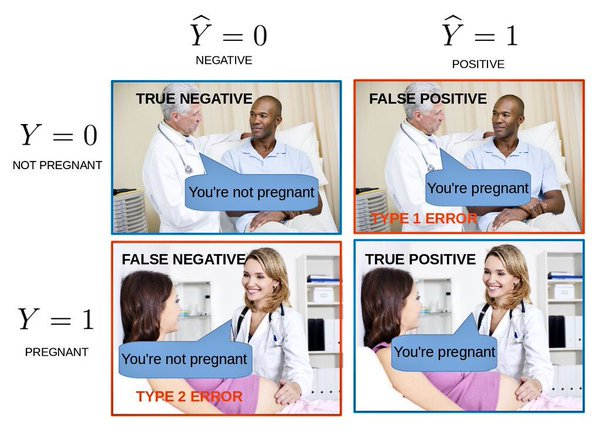

In [1]:
from IPython.display import Image
Image('https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg', width=600)

In [ ]:
전체예측데이터건수 / 예측데이터가동일한건수

In [ ]:
# 우리가 만든 모델이 얼마나 정확한지 판단하는 지표


In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
cm

array([[35,  2],
       [ 1, 76]], dtype=int64)

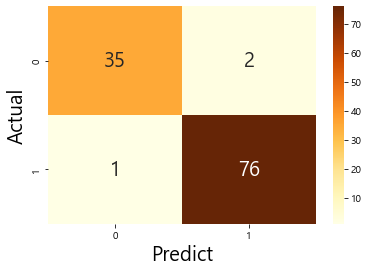

In [30]:
# 혼돈 행렬 시각화
sns.heatmap(cm, annot=True, annot_kws = {'size':20}, cmap='YlOrBr')
plt.xlabel('Predict', fontsize = 20)
plt.ylabel('Actual', fontsize = 20)
plt.show()

In [31]:
TN, FP, FN, TP = cm.ravel()

#### 정밀도(Precision)
- Positive로 예측한 전체 건수에서 옳게 예측한 건수의 비율

In [32]:
precision = TP / (FP + TP)
precision

0.9743589743589743

In [33]:
from sklearn.metrics import precision_score
precision_score(y_test, predict)

0.9743589743589743

#### 재현율(Recall), 민감도
- 실제 Positive인 전체 건수에서 옳게 예측한 건수의 비율
- TPR(True Positive Rate)

In [34]:
recall = TP / (FN + TP)
recall

0.987012987012987

In [35]:
from sklearn.metrics import recall_score
recall_score(y_test, predict)

0.987012987012987

#### F1 Score
- 재현율과 정밀도를 결합한 지표

In [36]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

0.9806451612903225

In [37]:
from sklearn.metrics import f1_score
f1_score(y_test, predict)

0.9806451612903225

# XGBoost 모델 학습
- 책 232p

## 위스콘신 유방암 예측

In [40]:
!pip install xgboost

In [45]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = datasets.data
labels = dataset.target
cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [46]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [47]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10&는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [48]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [49]:
params = {'max_depth':3,
         'eta':0.05,
         'objective':'binary:logistic',
         'eval_metric':'logloss'
         }
num_rounds = 400

### 주어진 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달하고 학습

In [51]:
# 학습 데이터셋을 'train' 또는 평가 데이터 셋은 'eval'로 명기합니다
eval_list = [(dtr, 'train'),(dval,'eval')]
# 또는 eval_list = [(dval, 'eval')]만 명기해도 무방

# 하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round=num_rounds,\
                     early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086


In [52]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정하여 List 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 : ', preds[:10])

predict() 수행결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시 :  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


## 평가 지표를 출력하는 get_clf_eval()함수 만들어서 예측 평가

In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score


In [60]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


In [58]:
# get_clf_eval(y_test, preds, pred_probs)

NameError: name 'get_clf_eval' is not defined

## Feature Importance 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

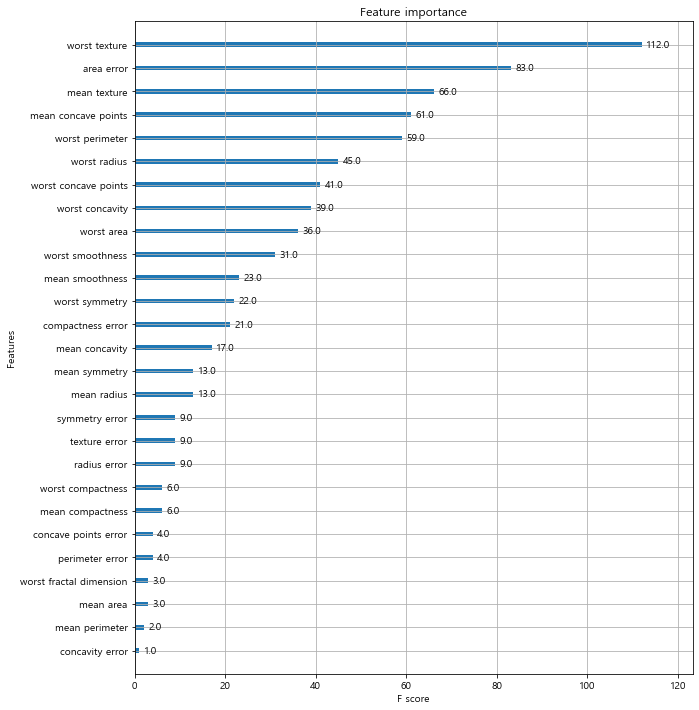

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

## scikit-learn XGBoost 실습

In [62]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력. 미 입력해도 수행에 문제 없음.   
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

### 평가 지표 출력

- XGBRegressot 하이퍼파라미터
 1. 일반 파라미터 : 부스팅을 수행할 때 트리를 사용할지, 선형 모델을 사용할지 등을 고려
   - booster[기본값 = gbtree] : 어떤 부스터 구조를 쓸지 결정
     - 의사결정기반모형(gbtree), 선형모형(gblinear), dart가 있다
   - n_jobs : XGBoost를 실행하는데 사용하는 병렬 스레드 수
  
 2. 부스터 파라미터 : 선택한 부스터에 따라서 적용할 수 있는 파라미터가 다르다
   - learning_rate[기본값 = 0.3] : 높을수록 과적합하기 쉽다
   - n_estimators[기본값 = 100] : 생설할 weak learner의 수, learning_rate가 낮을 때 높여야 과적합이 방지된다
   - max_depth[기본값 = 6] : 트리의 maximim dpth값, 적절한 값이 제시되어야 하고 보통 3-10 사이 값이 적용되며, max_depth가 높을수록 모델의 복잡도가 커져 과적합이 되기 쉽다
   - min_child_weight[기본값 = 1] : 관측치에 대한 가중치 합의 최소를 말하며 값이 높을수록 과적합이 방지된다
   - gamma[기본값 = 0] : 리프노트의 추가분할을 결정할 최소손실 감소값, 해당 값보다 손실이 크게 감소할 때 분리한다

 3. 학습 과정 파라미터 : 학습 시나리오를 결정한다

In [63]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


### early stopping을 50으로 설정하고 재 학습/예측/평가

In [71]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

[130]	validation_0-logloss:0.01886	validation_1-logloss:0.25712
[131]	validation_0-logloss:0.01863	validation_1-logloss:0.25609
[132]	validation_0-logloss:0.01839	validation_1-logloss:0.25649
[133]	validation_0-logloss:0.01816	validation_1-logloss:0.25789
[134]	validation_0-logloss:0.01802	validation_1-logloss:0.25811
[135]	validation_0-logloss:0.01785	validation_1-logloss:0.25794
[136]	validation_0-logloss:0.01763	validation_1-logloss:0.25876
[137]	validation_0-logloss:0.01748	validation_1-logloss:0.25884
[138]	validation_0-logloss:0.01732	validation_1-logloss:0.25867
[139]	validation_0-logloss:0.01719	validation_1-logloss:0.25876
[140]	validation_0-logloss:0.01696	validation_1-logloss:0.25987
[141]	validation_0-logloss:0.01681	validation_1-logloss:0.25960
[142]	validation_0-logloss:0.01669	validation_1-logloss:0.25982
[143]	validation_0-logloss:0.01656	validation_1-logloss:0.25992
[144]	validation_0-logloss:0.01638	validation_1-logloss:0.26035
[145]	validation_0-logloss:0.01623	valid

In [65]:
get_clf_eval(y_test , ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9933


- 지표들이 조금씩 떨어졌는데 원래 early stopping 하면 조금 상승해야 정상
이건 그에 맞는 예제가 아닌 듯

### early stopping을 10으로 설정하고 재 학습/예측/평가

In [67]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

- 이렇게 너무 일찍 early stoppping 해버리면 성능이 하락할 수 있음

### Feature Importance 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

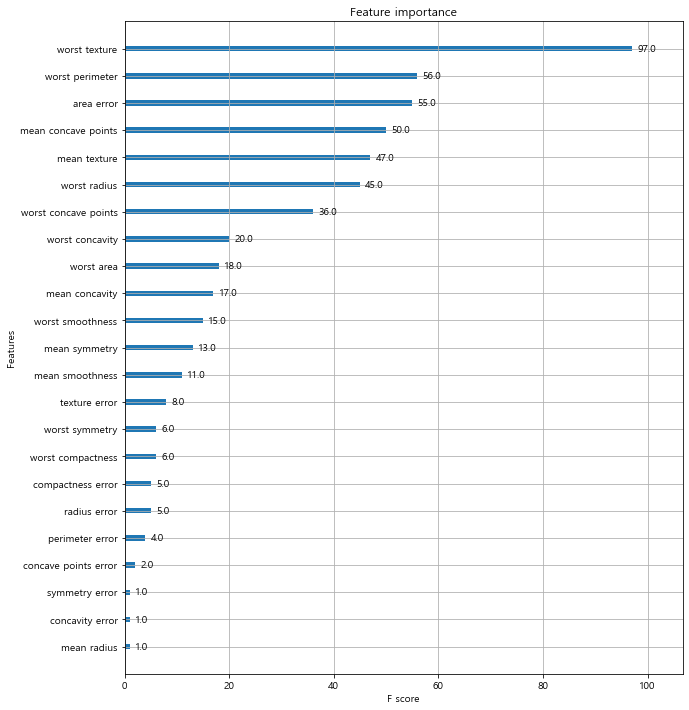

In [68]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

- **민감하게 조정해야 하는 것**
  - booster 모양
  - eval_metric(평가함수) / objective(목적함수)
  - eta
  - L1 form (L1 레귤러라이제이션 폼이 L2보다 아웃라이어에 민감하다)
  - L2 form
<br></br>
- 과적합 방지를 위해 조정해야 하는 것
  - learning rate 낮추기 -> n_estimators는 높여야 함
  - max_depth 낮추기
  - min_child_weight 높이기
  - gamma 높이기
  - subsample, colsample_bytree 낮추기

## LightGBM

1. lightGBM 장단점
    - XGB보다도 학습에 걸리는 시간이 훨씬 적으며 메모리 사용량도 상대적으로 적다
    - 카테고리형 피처를 자동 변환하고, 예측 성능 역시 큰 차이가 없다.
 2. 트리 기반 알고리즘 특징
     - 기존의 대부분 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level Wise) 방식을 사용한다.
     - 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 깊이가 최소화 되며 오버피팅에 보다 강한 구조를 가진다.
     - 하지만 규형을 맞추기 위한 시간이 오래 걸리는 단점이 있다.
 3. lightGBM 특징
     - lightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할(Leaf wise)방식을 사용한다.
     - 트리의 균형을 맞추지 않고 최대 손실값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하여 깊이가 증가하고 비대칭적인 트리를 생성한다.
     - 이렇게 생성된 트리는 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화 할 수 있다는 것이 LightGBM 구현사상이다.

- XGBoost 대비 장점

1. 더 빠른 학습과 예측 수행 시간
2. 더 작은 메모리 사용량
3. 카테고리형 피처의 자동 변환과 최적 분할
-> (원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환, 노드 분할 수행)
4. 일반적으로 XGBoost를 포함한 GBM 계열은 균형 트리 분할을 함 (depth 최소화)
5. 근데 LightGBM은 리프 중심 트리 분할을 함 (depth 신경 안 씀)


In [69]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target

cancer_df.info()

ModuleNotFoundError: No module named 'lightgbm'